# Window Splitters in Sktime

In this notebook we describe the window splitters inicluded in the [`sktime.forecasting.model_selection`](https://github.com/alan-turing-institute/sktime/blob/master/sktime/forecasting/model_selection/_split.py) module. These splitters can be combined with `ForecastingGridSearchCV` for model selection (see [forecasting notebook](https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb)). 

## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    CutoffSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

## Data

We use a fraction of the Box-Jenkins univariate airline data set, which shows the number of international airline passengers per month from 1949 - 1960. 

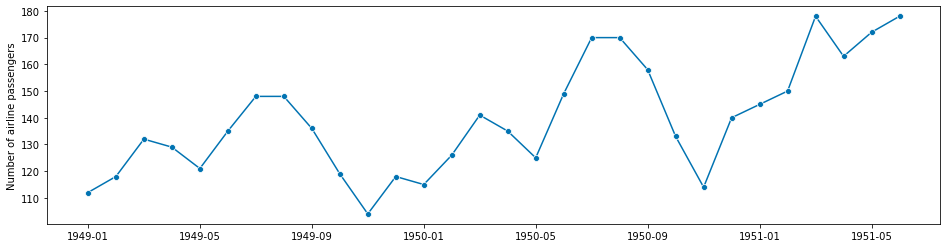

In [2]:
y = load_airline()[:30]

fig, ax = plot_series(y)

## Window Splitters

Now we describe each of the splitters.  

### - `temporal_train_test_split`

This one splits the data into a traininig and test sets.

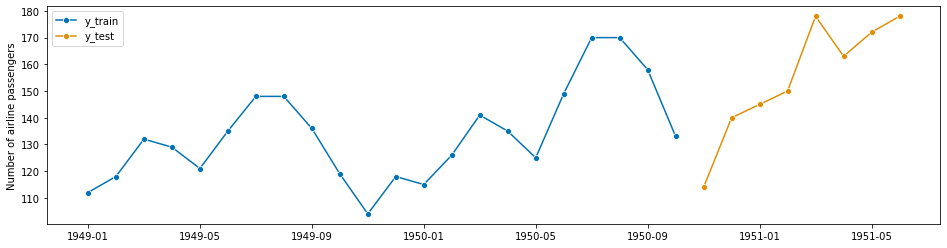

In [3]:
y_train, y_test = temporal_train_test_split(y=y, test_size=0.25)

plot_series(y_train, y_test, labels=["y_train", "y_test"]);

### - `SingleWindowSplitter`

This class splits the time series once into a training and test window. Note that this is very similar to `temporal_train_test_split`.

Let us definie the parameters of our fold:

In [4]:
# Spliitter Parameters
window_length = 10
fh = ForecastingHorizon([1, 2, 3])
fh_length = len(fh)

In [5]:
cv = SingleWindowSplitter(window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 1


Let us plot the unique fold generated.

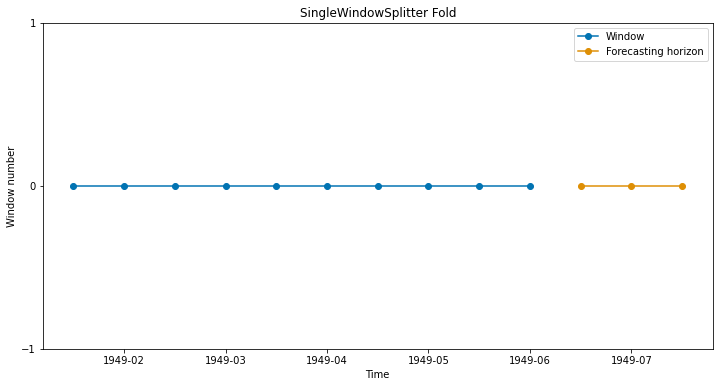

In [6]:
windows = np.empty((n_splits, window_length), dtype=np.int)
fhs = np.empty((n_splits, fh_length), dtype=np.int)
for i, (w, f) in enumerate(cv.split(y)):
    windows[i] = w
    fhs[i] = f


def get_y(length, split):
    return np.ones(length) * split


fig, ax = plt.subplots(figsize=(12, 6))

window_color, fh_color = sns.color_palette("colorblind")[:2]

for i in range(n_splits):
    ax.plot(
        windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window"
    )
    ax.plot(
        fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon"
    )
ax.invert_yaxis()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(
    title="SingleWindowSplitter Fold",
    ylabel="Window number",
    xlabel="Time",
    xticklabels=y.index,
    ylim=(-1, 1),
)
# remove duplicate labels/handles
handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
ax.legend(handles, labels);

### - `SlidingWindowSplitter`

This splitter generates folds which move with time. The length of the traiiining and test sets for each fold remains cosntant.

In [7]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 18


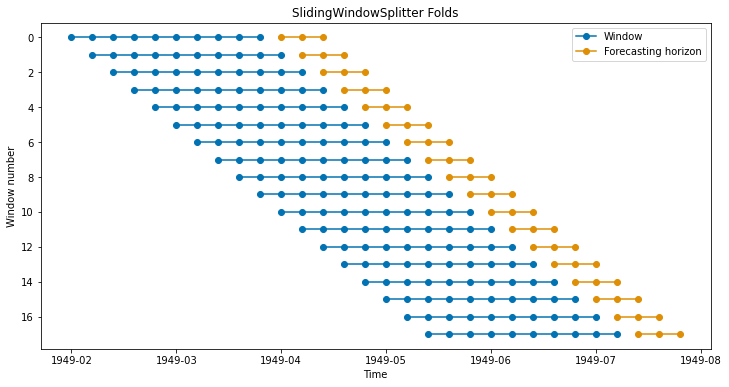

In [8]:
windows = np.empty((n_splits, window_length), dtype=np.int)
fhs = np.empty((n_splits, fh_length), dtype=np.int)
for i, (w, f) in enumerate(cv.split(y)):
    windows[i] = w
    fhs[i] = f

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(n_splits):
    ax.plot(
        windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window"
    )
    ax.plot(
        fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon"
    )
ax.invert_yaxis()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(
    title="SlidingWindowSplitter Folds",
    ylabel="Window number",
    xlabel="Time",
    xticklabels=y.index,
)
# remove duplicate labels/handles
handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
ax.legend(handles, labels);

### - `CutoffSplitter`

With this aplitter we can manually select the cutoff points.

In [9]:
# Specify cutoff points (by array index).
cutoffs = np.array([10, 15, 20, 25])

cv = CutoffSplitter(cutoffs=cutoffs, window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 4


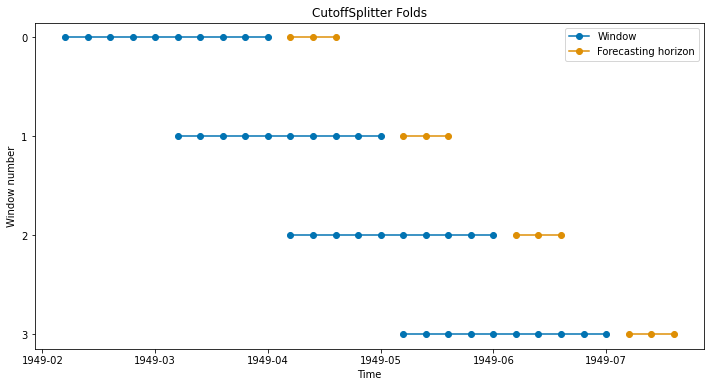

In [10]:
windows = np.empty((n_splits, window_length), dtype=np.int)
fhs = np.empty((n_splits, fh_length), dtype=np.int)
for i, (w, f) in enumerate(cv.split(y)):
    windows[i] = w
    fhs[i] = f

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(n_splits):
    ax.plot(
        windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window"
    )
    ax.plot(
        fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon"
    )
ax.invert_yaxis()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(
    title="CutoffSplitter Folds",
    ylabel="Window number",
    xlabel="Time",
    xticklabels=y.index,
)
# remove duplicate labels/handles
handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
ax.legend(handles, labels);
